In [1]:
from main import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%%time 
#Fitting for Model 1: (without CD) #using curve_fit
fit = Fitting('KMC_NonDynamic_Data_iCovg_iRates.csv','Atomic.csv','Stoich.csv','Param.csv',Input_Type='iCovg_iRates') #covgdep = Allowing for coverage dependance to be considered in the fit
fit.set_rxnconditions() #Sets the Pressures and Temperature as defined from the Param file. (Note: One can also enter them manually - See main.py for syntax)
fit.set_limits_of_integration(fit.Input.iloc[0,0],fit.Input.iloc[-1,0])
fit.n_extract = 0.5

Mass is conserved. 

CPU times: user 24.7 ms, sys: 3.04 ms, total: 27.7 ms
Wall time: 32.5 ms


In [3]:
fit.paramorderinfo(Param='Coverage')


 Order for Input Coverages (Transient and Steady State) [ML]:
             theta_CO  theta_O  theta_O2  theta_*
Array order         0        1         2        3


<IPython.core.display.Javascript object>


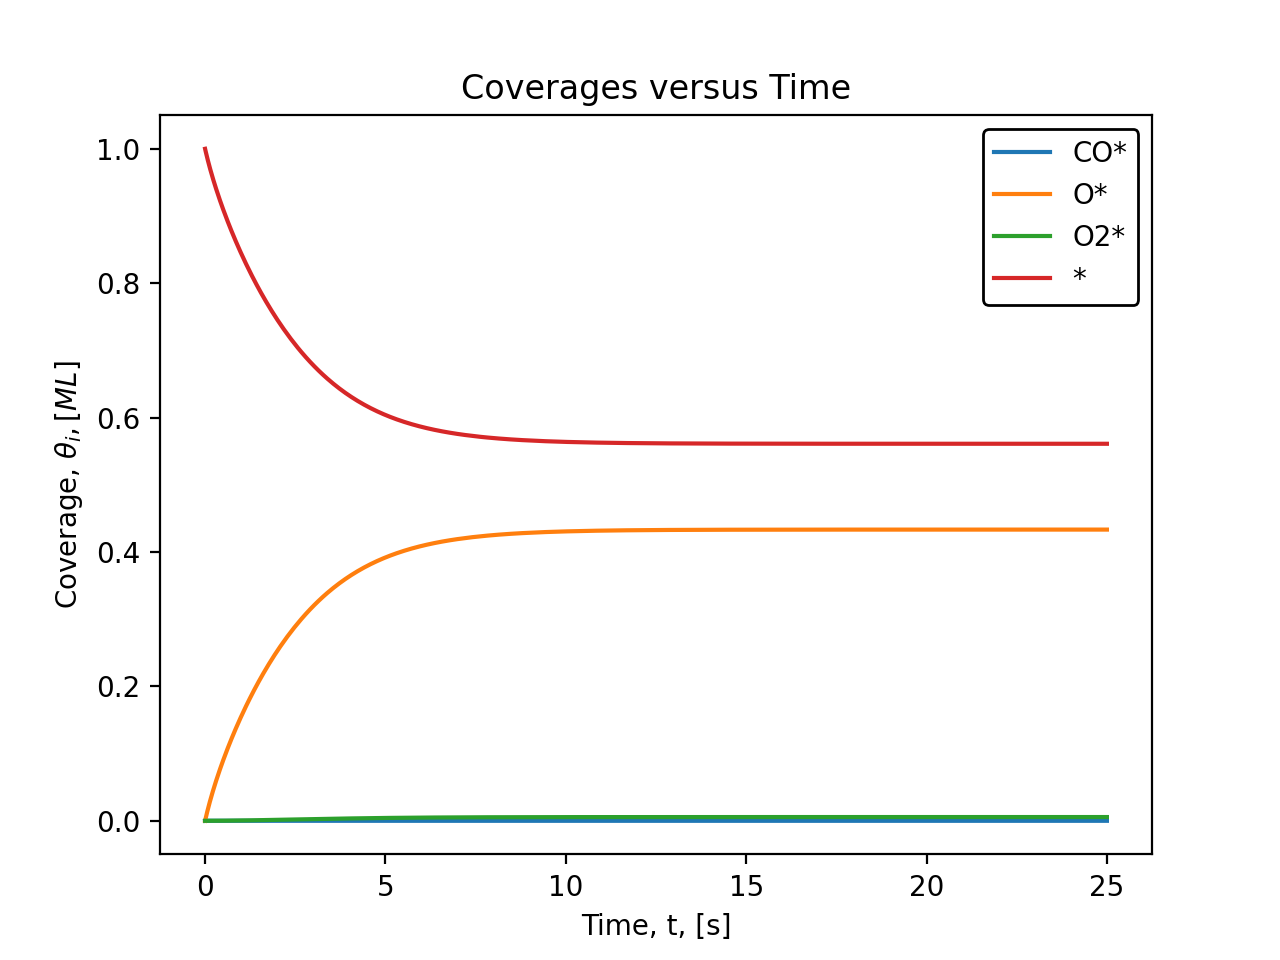

In [4]:
kfit1 = np.array([7.79027001e+06, 2.76471157e+03, 9.33338097e+06, 6.22390802e+00,
 9.33374875e+05, 1.55909555e+04, 3.86227078e+04, 5.32781881e+06])
fit.MKM.k = kfit1
sola1,solta1= fit.MKM.solve_coverage(plot=True) #Obtains the coverages(sol) with respect to time(solt) and plots them if plot=True (Note: Additional options can be set manually - See main.py for syntax)

<IPython.core.display.Javascript object>


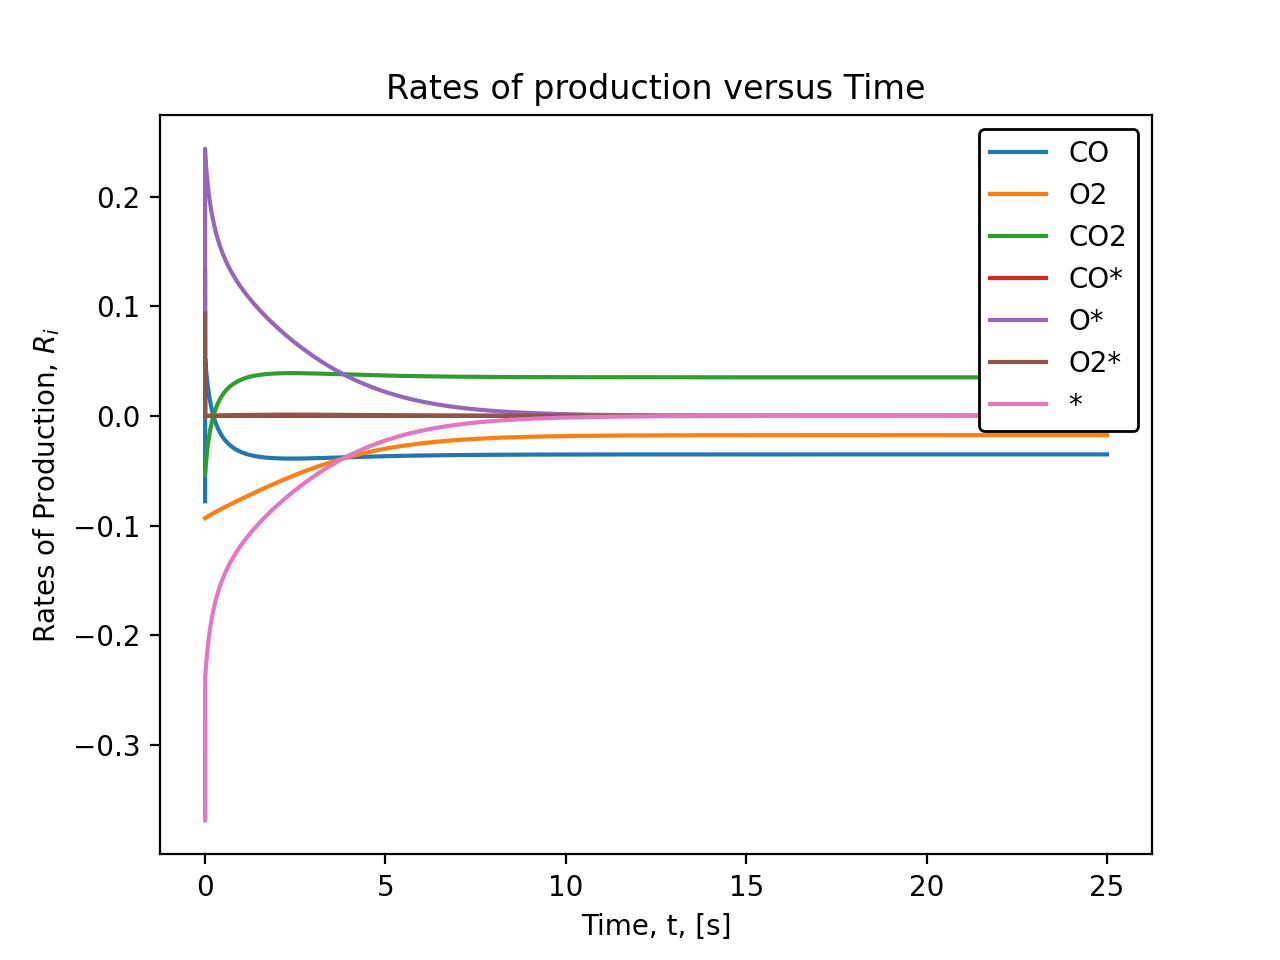

In [5]:
solb1,soltb1 = fit.MKM.solve_rate_production(plot=True)

### Comparing steady state rates of prod.

In [6]:
#From KMC Input:
# Extracting Steady State (Stoichiometric Information on OVERALL REACTION is Needed!!)
##In this case we have CO + 1/2 O2 -> CO2 (Order in Kinetic info database:[ CO, O2, CO2])
##Therefore Stoch matrix = [R_CO/R_CO2 , R_O2/RCO2, R_CO2/R_CO2] = [1,0.5,1]
Tol = 0.02 #This is maximum allowed %difference in stoichiometry and therefore the Tolerance
Act_stoic = np.array([1.0,0.5,1.0]) #Actuall expected stoichiometry according to the equation above
i = 0 #Initializing the -ve counter used to select number of points to average for steady state
Rates_p = fit.Input.to_numpy()[:,-(len(fit.Pextract())):] #Extracting the rates of production (Note order must match stoich vector)
for j in np.arange(len(fit.Input.to_numpy())): #looping through all possible data points
    i = i + 1
    ss_rate = np.average(Rates_p[-i:], axis=0)
    ss_rate_stoich = abs(ss_rate/ss_rate[-1])
    ss_rate_diff = max(abs(Act_stoic-ss_rate_stoich)/ss_rate_stoich)
    if i==len(fit.Input.to_numpy()): #Check to notify that all data points were used and hence SS wasnt reached
        raise Exception('\n STEADY STATE NOT REACHED!\n You may want to change the tolerance number')
    if ss_rate_diff<Tol: #Check to see if max %diff in stoich is less than tolerance
        KMC_ss_rate_diff = ss_rate
        break
    else:
        continue      

print('KMC Gaseous Rates of production/comnsumption:')
KMC_ss_rate_diff

array([-0.03038194, -0.01576542,  0.03098831])

In [7]:
#From Simulation (With fitted rate constants)
print('Simulation Gaseous Rates of production/comnsumption:')
RateVec = fit.MKM.get_SS_rates_production()[:len(fit.MKM.Pextract())]
RateVec

array([-0.03513383, -0.0175671 ,  0.03513383])

In [8]:
#Calculating %difference
pd = np.empty(len(RateVec))
for i in np.arange(len(RateVec)):
    pd[i] = np.abs((KMC_ss_rate_diff[i]-RateVec[i])/(KMC_ss_rate_diff[i]))*100

In [9]:
pd

array([15.64049599, 11.42805084, 13.37770566])

### Degree of rate control

Original format:
$$X_{RC_i} = \frac{d ln(r)}{d ln k_i} $$

Simplified:

$$X_{RC_i}=\frac{r_{new_i} - r_o}{p_{inc}*r_o} $$

Note:

$r_{new_i}$ : The rate of the designated reaction i of whose rate constants where increased by $p_{inc}$

$p_{inc}$ : Percent increase applied to the rate constants of the designated rate being studied. (All other rate constants for the other reactions remain unchanged)

$r_o$ : The rate of reaction of the step being compared against (Usually the production or synthesis step)

In [10]:
fit.MKM.get_X_RC_SS(k_o_inp=kfit1)

[0.9115495623077258,
 -5.032771108123902,
 -4.999930219440472,
 0.14038626451393751]